In [1]:
#!python -m pip install torch
import torch
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
#!python -m pip install tensorflow
import auto_encoder
import math
import bisect
import pickle
import copy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed(num_samples):
    pts = []
    i = 0
    it1 = int(math.sqrt(num_samples)/10)
    it2 = int((num_samples/10) - math.sqrt(num_samples))
    for j in range (10):
        for k in range(10):
            pts.append(i)
            i+=it1
        i+=it2
    return pts

In [3]:
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 

In [4]:
def error_points(predicted, truth, num):
    diffs = abs((predicted+1) - (truth+1))/(truth+1)
    array = np.mean(diffs, axis=1)
    points = (-np.asarray(array)).argsort()[:num]
    return points


In [5]:
def mean_error(predicted, truth):
    diffs = abs((predicted+1) - (truth+1))/(truth+1)
    return np.mean(np.mean(diffs, axis=1)) 

def max_error(predicted, truth):
    diffs = abs((predicted+1) - (truth+1))/(truth+1)
    array = np.mean(diffs, axis=1)
    return np.sort(array)[np.size(array)-1]

In [6]:
def error_data(mag, mag_t):
    diffs = abs(((mag+1) - (mag_t+1))/(mag_t+1))
    return np.mean(diffs, axis=1)

In [7]:
def print_points(data1, qubits, error_points):    
    data = np.load(data1)
    Bx = data['fields'].T[qubits]
    Bz = data['fields'].T[2*qubits]
    points = []
    for i in error_points:
        points.append((Bx[i],Bz[i]))
    print(points)

In [8]:
def expand_pool(old_pool, error_points, max_pool_size):
    for i in error_points:
        num = int(i)
        if(i not in old_pool):
            bisect.insort(old_pool,i)
        else:
            Bz_low_num = num-1
            Bz_high_num= num+1
            Bz_low_flag=True
            Bz_high_flag=True
            
            Bx_low_num = int(num-math.sqrt(max_pool_size))
            Bx_high_num= int(num+math.sqrt(max_pool_size))
            Bx_low_flag=True
            Bx_high_flag=True
            
            while(Bz_low_flag or Bz_high_flag or Bx_low_flag or Bx_high_flag):
                if(Bz_low_flag):
                    if(Bz_low_num<=0 or Bz_low_num % math.sqrt(max_pool_size)==math.sqrt(max_pool_size)-1):
                        Bz_low_flag=False
                    elif(Bz_low_num not in old_pool):
                        bisect.insort(old_pool,Bz_low_num)
                        Bz_low_flag=False
                    else:
                        Bz_low_num-=1
                if(Bz_high_flag):
                    if(Bz_high_num>=max_pool_size or Bz_high_num % math.sqrt(max_pool_size)==0):
                        Bz_high_flag=False
                    elif(Bz_high_num not in old_pool):
                        bisect.insort(old_pool, Bz_high_num)
                        Bz_high_flag=False
                    else:
                        Bz_high_num+=1
                if(Bx_low_flag):
                    if(Bx_low_num<=0):
                        Bx_low_flag=False
                    elif(Bx_low_num not in old_pool):
                        bisect.insort(old_pool, Bx_low_num)
                        Bx_low_flag=False
                    else:
                        Bx_low_num-=int(math.sqrt(max_pool_size))
                if(Bx_high_flag):
                    if(Bx_high_num>=max_pool_size or Bx_high_num % math.sqrt(max_pool_size)==0):
                        Bx_high_flag=False
                    elif(Bx_high_num not in old_pool):
                        bisect.insort(old_pool, Bx_high_num)
                        Bx_high_flag=False
                    else:
                        Bx_high_num+=int(math.sqrt(max_pool_size))    
                    
    return old_pool

In [12]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data_1.npz'
data_4 = '4_qubit_crit_data_1.npz'
data_6 = '6_qubit_crit_data_1.npz'
data_7 = '7_qubit_crit_data_1.npz'
data_8 = '8_qubit_crit_data.npz'

v_data_2 = '2_qubit_val_data.npz'
v_data_4 = '4_qubit_val_data.npz'
v_data_7 = '7_qubit_val_data.npz'

data_3 = '3_qubit_test_data.npz'
data_5 = '5_qubit_test_data.npz'
data_10 = '10_qubit_test_data.npz'

#     val_data_9 = get_dataset(data_9, 9, pool_size)

validation_n_sizes = [6,8]
mps_size = 5
device = torch.device("cpu")
model = auto_encoder.MPS_autoencoder(mps_size = mps_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_sizes = [2,4,7]
val_sizes = [6,8,2,4,7]

pool_size = 10000
val_size = 1089

pts = seed(pool_size)
error_p = []
magnetization_6 = []
wave_func_6 = []
final_weights = []
final_grads = []

val_data_2 = get_dataset(v_data_2, 2, val_size)
val_data_4 = get_dataset(v_data_4, 4, val_size)
val_data_7 = get_dataset(v_data_7, 7, val_size)
val_data_6 = get_dataset(data_6, 6, pool_size)
val_data_8 = get_dataset(data_8, 8, 2500)


test_data_3 = get_dataset(data_3, 3, pool_size)
test_data_5 = get_dataset(data_5, 5, 2500)
test_data_10 = get_dataset(data_10, 10, 100)

val_datasets = [val_data_6, val_data_8, val_data_2, val_data_4, val_data_7] # val_data_9

val_loaders = [DataLoader(x, batch_size = 10, num_workers=5) for x in val_datasets]


val_6 = next(iter(val_loaders[0]))
val_8 = next(iter(val_loaders[1]))
val_2 = next(iter(val_loaders[2]))
val_4 = next(iter(val_loaders[3]))
val_7 = next(iter(val_loaders[4]))

stop = 500
runs = 0
prev_err = 999
prev_diff = 999
increase_points = 5

In [16]:
stop = .05
runs = 36
increase_points = 8
model.load_state_dict(torch.load("Active_st2.pt"))
mag_loaders = torch.load('mag_loaders.pth')
model.eval()
magnon_6 = np.load('magnetization_6_st1.npy')
magnetization_6 = magnon_6.tolist()
pots = np.load('pts_st1.npy')   
pts = pots.tolist()
errr_p = np.load('error_p_st1.npy')
error_p = errr_p.tolist()



TypeError: 'method' object is not subscriptable

In [19]:
print(model)
print(model.encoder[6].weight)
print(model.encoder[6].bias)


MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
Parameter containing:
tensor([[-0.0582,  0.0469, -0.0954,  ...,  0.1280, -0.1293,  0.5420],
        [ 0.1135, -0.1950, -0.0213,  ..., -0.0863, -0.0836, -0.0434],
        [ 0.0073, -0.1137,  0.1203,  ...,  0.1401, -0.1505,  0.0413],
        ...,
        [-0.0948, -0.0265,  0.0697,  ...,  0.0586, -0.0904,  0.0500],
        [ 0.0799, -0.0871,  0.1250,  ...,  0.0901,  0.0420,  0.1250],
        [-0.0805,  0.2465,  0.0739,  ...,  0.1106, -0.1293, -0.0038]],
       requires_grad=True)
Parameter containing:
tensor([ 0.1151, -0.3130,  0.1208, -0.0341,  0.2420, -0.4069,  0.2784, -0.0523,
         0.3459, -0.2349, -0.0725,  0.1377, -0.0057,  0.0990, -0.1703,  0.

In [13]:
while(True):
    runs = runs+1
    if(runs % 10 == 0):
        increase_points +=  1
        
        
    training_data_2 = auto_encoder.get_dataset_active(data_2,2,pool_size, pts)
    training_data_4 = auto_encoder.get_dataset_active(data_4,4,pool_size, pts)
    training_data_7 = auto_encoder.get_dataset_active(data_7,7,pool_size, pts) 


    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [val_data_2, test_data_3, val_data_4, test_data_5, val_data_6,val_data_7, val_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))

    magnetization_6.append(mag_6)
    
    final_weights.append(model.encoder[6].weight)
    final_grads.append(model.encoder[6].weight.grad)

    error_pts = error_points(data_y_6, data_y_6_t, increase_points)
    print("ERROR POINTS:")
    print_points(data_6, 6, error_pts)

    error_p.append(error_data(data_y_6,data_y_6_t))

    new_err = mean_error(data_y_6,data_y_6_t)
    new_diff = max_error(data_y_6,data_y_6_t) - new_err
    
    print((prev_diff-new_diff)/prev_diff)
    
    if(len(pts)<stop):
        pts = expand_pool(pts, error_pts, pool_size)
        print("NEW SET: ")
        print(pts)
        print()
        print("_________________________________")
        prev_err = new_err
        prev_diff = new_diff
    else:
        break


Training Validation  1
Epoch 2 : 	 Training_Error: 3.17098 	 Val Error: 3.63947
********************************************************************************
2_qubit_loss: 0.09779 	 	 |4_qubit_loss: 0.12919 	 	 |7_qubit_loss: 2.94400 	 	 |
********************************************************************************
6_qubit_loss: 0.22272 	 	 |8_qubit_loss: 0.33148 	 	 |2_qubit_loss: 0.04878 	 	 |4_qubit_loss: 0.13174 	 	 |7_qubit_loss: 2.90475 	 	 |



Epoch 4 : 	 Training_Error: 0.34172 	 Val Error: 0.28571
********************************************************************************
2_qubit_loss: 0.04260 	 	 |4_qubit_loss: 0.10280 	 	 |7_qubit_loss: 0.19633 	 	 |
********************************************************************************
6_qubit_loss: 0.05777 	 	 |8_qubit_loss: 0.08465 	 	 |2_qubit_loss: 0.02354 	 	 |4_qubit_loss: 0.04163 	 	 |7_qubit_loss: 0.07812 	 	 |



Epoch 6 : 	 Training_Error: 0.31620 	 Val Error: 0.27675
****************************************

Model converged!
VALIDATION LOSS ITERATION:  2
6 	 0.00230165827088058
8 	 0.002857100684195757
2 	 0.0008199044386856258
4 	 0.0015408340841531754
7 	 0.0018274032045155764
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(1.595959595959596, 0.45222222222222225), (1.575757575757576, 0.43212121212121213), (1.6161616161616164, 0.47232323232323237), (1.6161616161616164, 0.49242424242424243), (1.595959595959596, 0.43212121212121213)]
0.08799239
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 3000, 3010, 3020, 3030, 3

ERROR POINTS:
[(2.0, 0.01), (1.97979797979798, 0.01), (1.9595959595959598, 0.01), (1.9393939393939394, 0.01), (1.9191919191919193, 0.01)]
0.22999907
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 3000, 3010, 3020, 3030, 3040, 3050, 3060, 3070, 3080, 3090, 4000, 4010, 4020, 4030, 4040, 4050, 4060, 4070, 4080, 4090, 5000, 5010, 5020, 5030, 5040, 5050, 5060, 5070, 5080, 5090, 5700, 5800, 5801, 5900, 5901, 6000, 6001, 6010, 6020, 6030, 6040, 6050, 6060, 6070, 6080, 6090, 6100, 6200, 6409, 6510, 6610, 6711, 6811, 7000, 7010, 7020, 7030, 7040, 7050, 7060, 7070, 7080, 7090, 7821, 7921, 7922, 8000, 8010, 8020, 8023, 8024, 8030, 8040, 8050, 8060, 8070, 8080, 8090, 9000, 9010, 9020, 9030, 9040, 9050, 9060, 9070, 9080, 9090, 9500, 9600, 9700, 9800, 9900]

_________________________________
Training Validation  5
Epoch 2 : 	 Training_Error: 0.06208 	 Val Error: 0.01812
********

Model converged!
VALIDATION LOSS ITERATION:  6
6 	 0.011074455454945564
8 	 0.017111409455537796
2 	 0.002104217652231455
4 	 0.004988901317119598
7 	 0.01805851049721241
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.9494949494949496, 0.0703030303030303), (0.9696969696969697, 0.0703030303030303), (0.9292929292929294, 0.050202020202020206), (0.9494949494949496, 0.050202020202020206), (0.9696969696969697, 0.0904040404040404)]
-0.7609762
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 3000, 3010, 3020, 3030, 30

Epoch 10 : 	 Training_Error: 0.04531 	 Val Error: 0.02103
********************************************************************************
2_qubit_loss: 0.00387 	 	 |4_qubit_loss: 0.01292 	 	 |7_qubit_loss: 0.02851 	 	 |
********************************************************************************
6_qubit_loss: 0.00331 	 	 |8_qubit_loss: 0.01007 	 	 |2_qubit_loss: 0.00070 	 	 |4_qubit_loss: 0.00155 	 	 |7_qubit_loss: 0.00539 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  8
6 	 0.01375608704984188
8 	 0.022045964375138283
2 	 0.0034941311459988356
4 	 0.005296855699270964
7 	 0.022970426827669144
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)


Epoch 12 : 	 Training_Error: 0.05457 	 Val Error: 0.03147
********************************************************************************
2_qubit_loss: 0.00313 	 	 |4_qubit_loss: 0.01615 	 	 |7_qubit_loss: 0.03530 	 	 |
********************************************************************************
6_qubit_loss: 0.00646 	 	 |8_qubit_loss: 0.01292 	 	 |2_qubit_loss: 0.00115 	 	 |4_qubit_loss: 0.00322 	 	 |7_qubit_loss: 0.00773 	 	 |



Epoch 14 : 	 Training_Error: 0.04885 	 Val Error: 0.02094
********************************************************************************
2_qubit_loss: 0.00294 	 	 |4_qubit_loss: 0.01339 	 	 |7_qubit_loss: 0.03252 	 	 |
********************************************************************************
6_qubit_loss: 0.00438 	 	 |8_qubit_loss: 0.00591 	 	 |2_qubit_loss: 0.00174 	 	 |4_qubit_loss: 0.00290 	 	 |7_qubit_loss: 0.00602 	 	 |



Epoch 16 : 	 Training_Error: 0.03918 	 Val Error: 0.01960
************************************************************

Epoch 2 : 	 Training_Error: 0.07625 	 Val Error: 0.02002
********************************************************************************
2_qubit_loss: 0.00633 	 	 |4_qubit_loss: 0.01609 	 	 |7_qubit_loss: 0.05383 	 	 |
********************************************************************************
6_qubit_loss: 0.00353 	 	 |8_qubit_loss: 0.00782 	 	 |2_qubit_loss: 0.00128 	 	 |4_qubit_loss: 0.00203 	 	 |7_qubit_loss: 0.00535 	 	 |



Epoch 4 : 	 Training_Error: 0.05783 	 Val Error: 0.03015
********************************************************************************
2_qubit_loss: 0.00285 	 	 |4_qubit_loss: 0.01581 	 	 |7_qubit_loss: 0.03917 	 	 |
********************************************************************************
6_qubit_loss: 0.00493 	 	 |8_qubit_loss: 0.01380 	 	 |2_qubit_loss: 0.00051 	 	 |4_qubit_loss: 0.00152 	 	 |7_qubit_loss: 0.00940 	 	 |



Epoch 6 : 	 Training_Error: 0.04272 	 Val Error: 0.01280
***************************************************************

Epoch 2 : 	 Training_Error: 0.09272 	 Val Error: 0.06066
********************************************************************************
2_qubit_loss: 0.00581 	 	 |4_qubit_loss: 0.01969 	 	 |7_qubit_loss: 0.06722 	 	 |
********************************************************************************
6_qubit_loss: 0.01220 	 	 |8_qubit_loss: 0.02464 	 	 |2_qubit_loss: 0.00218 	 	 |4_qubit_loss: 0.00530 	 	 |7_qubit_loss: 0.01635 	 	 |



Epoch 4 : 	 Training_Error: 0.03883 	 Val Error: 0.01144
********************************************************************************
2_qubit_loss: 0.00236 	 	 |4_qubit_loss: 0.01066 	 	 |7_qubit_loss: 0.02582 	 	 |
********************************************************************************
6_qubit_loss: 0.00189 	 	 |8_qubit_loss: 0.00447 	 	 |2_qubit_loss: 0.00076 	 	 |4_qubit_loss: 0.00094 	 	 |7_qubit_loss: 0.00338 	 	 |



Epoch 6 : 	 Training_Error: 0.03061 	 Val Error: 0.01112
***************************************************************

Epoch 2 : 	 Training_Error: 0.03438 	 Val Error: 0.01400
********************************************************************************
2_qubit_loss: 0.00225 	 	 |4_qubit_loss: 0.00873 	 	 |7_qubit_loss: 0.02339 	 	 |
********************************************************************************
6_qubit_loss: 0.00293 	 	 |8_qubit_loss: 0.00370 	 	 |2_qubit_loss: 0.00078 	 	 |4_qubit_loss: 0.00174 	 	 |7_qubit_loss: 0.00485 	 	 |



Epoch 4 : 	 Training_Error: 0.03210 	 Val Error: 0.01844
********************************************************************************
2_qubit_loss: 0.00229 	 	 |4_qubit_loss: 0.00929 	 	 |7_qubit_loss: 0.02052 	 	 |
********************************************************************************
6_qubit_loss: 0.00311 	 	 |8_qubit_loss: 0.00800 	 	 |2_qubit_loss: 0.00156 	 	 |4_qubit_loss: 0.00112 	 	 |7_qubit_loss: 0.00465 	 	 |



Epoch 6 : 	 Training_Error: 0.03092 	 Val Error: 0.02295
***************************************************************

Epoch 2 : 	 Training_Error: 0.03153 	 Val Error: 0.01595
********************************************************************************
2_qubit_loss: 0.00230 	 	 |4_qubit_loss: 0.00784 	 	 |7_qubit_loss: 0.02138 	 	 |
********************************************************************************
6_qubit_loss: 0.00279 	 	 |8_qubit_loss: 0.00706 	 	 |2_qubit_loss: 0.00108 	 	 |4_qubit_loss: 0.00113 	 	 |7_qubit_loss: 0.00389 	 	 |



Epoch 4 : 	 Training_Error: 0.03438 	 Val Error: 0.02792
********************************************************************************
2_qubit_loss: 0.00351 	 	 |4_qubit_loss: 0.00677 	 	 |7_qubit_loss: 0.02410 	 	 |
********************************************************************************
6_qubit_loss: 0.00513 	 	 |8_qubit_loss: 0.00964 	 	 |2_qubit_loss: 0.00370 	 	 |4_qubit_loss: 0.00351 	 	 |7_qubit_loss: 0.00594 	 	 |



Epoch 6 : 	 Training_Error: 0.03035 	 Val Error: 0.01124
***************************************************************

Epoch 2 : 	 Training_Error: 0.02301 	 Val Error: 0.00945
********************************************************************************
2_qubit_loss: 0.00168 	 	 |4_qubit_loss: 0.00456 	 	 |7_qubit_loss: 0.01676 	 	 |
********************************************************************************
6_qubit_loss: 0.00147 	 	 |8_qubit_loss: 0.00375 	 	 |2_qubit_loss: 0.00053 	 	 |4_qubit_loss: 0.00086 	 	 |7_qubit_loss: 0.00282 	 	 |



Epoch 4 : 	 Training_Error: 0.02477 	 Val Error: 0.00826
********************************************************************************
2_qubit_loss: 0.00168 	 	 |4_qubit_loss: 0.00710 	 	 |7_qubit_loss: 0.01600 	 	 |
********************************************************************************
6_qubit_loss: 0.00128 	 	 |8_qubit_loss: 0.00332 	 	 |2_qubit_loss: 0.00066 	 	 |4_qubit_loss: 0.00094 	 	 |7_qubit_loss: 0.00206 	 	 |



Epoch 6 : 	 Training_Error: 0.02683 	 Val Error: 0.00975
***************************************************************

Epoch 18 : 	 Training_Error: 0.02415 	 Val Error: 0.01153
********************************************************************************
2_qubit_loss: 0.00134 	 	 |4_qubit_loss: 0.00807 	 	 |7_qubit_loss: 0.01474 	 	 |
********************************************************************************
6_qubit_loss: 0.00245 	 	 |8_qubit_loss: 0.00284 	 	 |2_qubit_loss: 0.00074 	 	 |4_qubit_loss: 0.00200 	 	 |7_qubit_loss: 0.00350 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  21
6 	 0.007355680223554373
8 	 0.010891974903643131
2 	 0.0014517900999635458
4 	 0.0028348839841783047
7 	 0.01150696724653244
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True

Epoch 2 : 	 Training_Error: 0.01845 	 Val Error: 0.01062
********************************************************************************
2_qubit_loss: 0.00186 	 	 |4_qubit_loss: 0.00477 	 	 |7_qubit_loss: 0.01181 	 	 |
********************************************************************************
6_qubit_loss: 0.00176 	 	 |8_qubit_loss: 0.00507 	 	 |2_qubit_loss: 0.00068 	 	 |4_qubit_loss: 0.00084 	 	 |7_qubit_loss: 0.00228 	 	 |



Epoch 4 : 	 Training_Error: 0.01674 	 Val Error: 0.00908
********************************************************************************
2_qubit_loss: 0.00114 	 	 |4_qubit_loss: 0.00372 	 	 |7_qubit_loss: 0.01189 	 	 |
********************************************************************************
6_qubit_loss: 0.00135 	 	 |8_qubit_loss: 0.00460 	 	 |2_qubit_loss: 0.00033 	 	 |4_qubit_loss: 0.00057 	 	 |7_qubit_loss: 0.00223 	 	 |



Epoch 6 : 	 Training_Error: 0.01574 	 Val Error: 0.00757
***************************************************************

Model converged!
VALIDATION LOSS ITERATION:  24
6 	 0.013724478892982006
8 	 0.01922762766480446
2 	 0.004111103247851133
4 	 0.006570781581103802
7 	 0.018472235649824142
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.9292929292929294, 0.050202020202020206), (0.9494949494949496, 0.050202020202020206), (0.9494949494949496, 0.0301010101010101), (0.9292929292929294, 0.0301010101010101), (0.9696969696969697, 0.050202020202020206), (0.9090909090909092, 0.0301010101010101), (0.98989898989899, 0.050202020202020206)]
-1.2464023
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1010, 10

Epoch 2 : 	 Training_Error: 0.01632 	 Val Error: 0.01170
********************************************************************************
2_qubit_loss: 0.00207 	 	 |4_qubit_loss: 0.00519 	 	 |7_qubit_loss: 0.00906 	 	 |
********************************************************************************
6_qubit_loss: 0.00214 	 	 |8_qubit_loss: 0.00546 	 	 |2_qubit_loss: 0.00113 	 	 |4_qubit_loss: 0.00116 	 	 |7_qubit_loss: 0.00182 	 	 |



Epoch 4 : 	 Training_Error: 0.01530 	 Val Error: 0.00576
********************************************************************************
2_qubit_loss: 0.00134 	 	 |4_qubit_loss: 0.00374 	 	 |7_qubit_loss: 0.01023 	 	 |
********************************************************************************
6_qubit_loss: 0.00065 	 	 |8_qubit_loss: 0.00312 	 	 |2_qubit_loss: 0.00050 	 	 |4_qubit_loss: 0.00042 	 	 |7_qubit_loss: 0.00107 	 	 |



Epoch 6 : 	 Training_Error: 0.01226 	 Val Error: 0.00492
***************************************************************

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(0.98989898989899, 0.0301010101010101), (0.9696969696969697, 0.0301010101010101), (0.9494949494949496, 0.0301010101010101), (0.9292929292929294, 0.0301010101010101), (1.0101010101010102, 0.0301010101010101), (0.9090909090909092, 0.0301010101010101), (0.888888888888889, 0.0301010101010101)]
-0.012083034
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1200, 1300, 1400, 1500, 1600, 1601, 1700, 1701, 1800, 1801, 1900, 1901, 2000, 2001, 2002, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2101, 2102, 2200, 2201, 2202,

Epoch 2 : 	 Training_Error: 0.01911 	 Val Error: 0.02048
********************************************************************************
2_qubit_loss: 0.00198 	 	 |4_qubit_loss: 0.00592 	 	 |7_qubit_loss: 0.01121 	 	 |
********************************************************************************
6_qubit_loss: 0.00448 	 	 |8_qubit_loss: 0.00749 	 	 |2_qubit_loss: 0.00142 	 	 |4_qubit_loss: 0.00316 	 	 |7_qubit_loss: 0.00392 	 	 |



Epoch 4 : 	 Training_Error: 0.01624 	 Val Error: 0.01627
********************************************************************************
2_qubit_loss: 0.00175 	 	 |4_qubit_loss: 0.00390 	 	 |7_qubit_loss: 0.01059 	 	 |
********************************************************************************
6_qubit_loss: 0.00344 	 	 |8_qubit_loss: 0.00652 	 	 |2_qubit_loss: 0.00131 	 	 |4_qubit_loss: 0.00202 	 	 |7_qubit_loss: 0.00298 	 	 |



Epoch 6 : 	 Training_Error: 0.01261 	 Val Error: 0.00907
***************************************************************

Model converged!
VALIDATION LOSS ITERATION:  30
6 	 0.01076340489089489
8 	 0.014715282246470451
2 	 0.00153312087059021
4 	 0.0053267753683030605
7 	 0.01380196027457714
__________________________________________________

MPS_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=50, bias=True)
  )
)
ERROR POINTS:
[(1.2525252525252526, 0.01), (1.272727272727273, 0.01), (1.2323232323232325, 0.01), (1.292929292929293, 0.01), (1.2121212121212122, 0.01), (1.3131313131313131, 0.01), (1.474747474747475, 0.01), (1.494949494949495, 0.01)]
0.6568667
NEW SET: 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1200, 1300, 1400, 1500, 1600, 

Epoch 2 : 	 Training_Error: 0.01083 	 Val Error: 0.00809
********************************************************************************
2_qubit_loss: 0.00126 	 	 |4_qubit_loss: 0.00384 	 	 |7_qubit_loss: 0.00573 	 	 |
********************************************************************************
6_qubit_loss: 0.00148 	 	 |8_qubit_loss: 0.00195 	 	 |2_qubit_loss: 0.00097 	 	 |4_qubit_loss: 0.00124 	 	 |7_qubit_loss: 0.00245 	 	 |



Epoch 4 : 	 Training_Error: 0.01274 	 Val Error: 0.00838
********************************************************************************
2_qubit_loss: 0.00169 	 	 |4_qubit_loss: 0.00477 	 	 |7_qubit_loss: 0.00629 	 	 |
********************************************************************************
6_qubit_loss: 0.00089 	 	 |8_qubit_loss: 0.00256 	 	 |2_qubit_loss: 0.00315 	 	 |4_qubit_loss: 0.00073 	 	 |7_qubit_loss: 0.00103 	 	 |



Epoch 6 : 	 Training_Error: 0.01384 	 Val Error: 0.01055
***************************************************************

Epoch 8 : 	 Training_Error: 0.00855 	 Val Error: 0.00711
********************************************************************************
2_qubit_loss: 0.00091 	 	 |4_qubit_loss: 0.00215 	 	 |7_qubit_loss: 0.00549 	 	 |
********************************************************************************
6_qubit_loss: 0.00137 	 	 |8_qubit_loss: 0.00248 	 	 |2_qubit_loss: 0.00100 	 	 |4_qubit_loss: 0.00104 	 	 |7_qubit_loss: 0.00121 	 	 |



Epoch 10 : 	 Training_Error: 0.00956 	 Val Error: 0.00691
********************************************************************************
2_qubit_loss: 0.00095 	 	 |4_qubit_loss: 0.00249 	 	 |7_qubit_loss: 0.00611 	 	 |
********************************************************************************
6_qubit_loss: 0.00131 	 	 |8_qubit_loss: 0.00227 	 	 |2_qubit_loss: 0.00084 	 	 |4_qubit_loss: 0.00109 	 	 |7_qubit_loss: 0.00140 	 	 |



Epoch 12 : 	 Training_Error: 0.00934 	 Val Error: 0.00632
*************************************************************

Epoch 14 : 	 Training_Error: 0.00788 	 Val Error: 0.00388
********************************************************************************
2_qubit_loss: 0.00113 	 	 |4_qubit_loss: 0.00240 	 	 |7_qubit_loss: 0.00434 	 	 |
********************************************************************************
6_qubit_loss: 0.00052 	 	 |8_qubit_loss: 0.00092 	 	 |2_qubit_loss: 0.00092 	 	 |4_qubit_loss: 0.00052 	 	 |7_qubit_loss: 0.00099 	 	 |



Epoch 16 : 	 Training_Error: 0.00972 	 Val Error: 0.00565
********************************************************************************
2_qubit_loss: 0.00127 	 	 |4_qubit_loss: 0.00311 	 	 |7_qubit_loss: 0.00534 	 	 |
********************************************************************************
6_qubit_loss: 0.00096 	 	 |8_qubit_loss: 0.00155 	 	 |2_qubit_loss: 0.00078 	 	 |4_qubit_loss: 0.00081 	 	 |7_qubit_loss: 0.00155 	 	 |



Model converged!
VALIDATION LOSS ITERATION:  34
6 	 0.005072562023997307
8 	 0.007385489530861378
2 	 0.00088053214130

Epoch 2 : 	 Training_Error: 0.00965 	 Val Error: 0.00553
********************************************************************************
2_qubit_loss: 0.00104 	 	 |4_qubit_loss: 0.00318 	 	 |7_qubit_loss: 0.00543 	 	 |
********************************************************************************
6_qubit_loss: 0.00091 	 	 |8_qubit_loss: 0.00118 	 	 |2_qubit_loss: 0.00111 	 	 |4_qubit_loss: 0.00108 	 	 |7_qubit_loss: 0.00125 	 	 |



Epoch 4 : 	 Training_Error: 0.01094 	 Val Error: 0.01084
********************************************************************************
2_qubit_loss: 0.00118 	 	 |4_qubit_loss: 0.00344 	 	 |7_qubit_loss: 0.00632 	 	 |
********************************************************************************
6_qubit_loss: 0.00248 	 	 |8_qubit_loss: 0.00190 	 	 |2_qubit_loss: 0.00090 	 	 |4_qubit_loss: 0.00251 	 	 |7_qubit_loss: 0.00305 	 	 |



Epoch 6 : 	 Training_Error: 0.01075 	 Val Error: 0.01074
***************************************************************

In [16]:
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

In [21]:
from tempfile import TemporaryFile

with open('magnetization_6_pr.npy', 'wb') as f:
    np.save(f, magnetization_6)

with open('pts_pr.npy', 'wb') as f:
    np.save(f, pts)   
    
with open('error_p_pr.npy', 'wb') as f:
    np.save(f,error_p)

with open('final_weights_pr.npy','wb') as f:
    np.save(f, final_weights)
    
# with open('final_grads_pr.pt','wb') as f:
#     torch.save(f, final_grads)

torch.save(mag_loaders, 'mag_loaders_pr.pth')    
torch.save(model.state_dict(), "Active_pr.pt")

In [ ]:
print("2: ", mean_error(data_y_2,data_y_2_t)*100)
print("3: ", mean_error(data_y_3,data_y_3_t)*100)
print("4: ", mean_error(data_y_4,data_y_4_t)*100)
print("5: ", mean_error(data_y_5,data_y_5_t)*100)
print("6: ", mean_error(data_y_6,data_y_6_t)*100)
print("7: ", mean_error(data_y_7,data_y_7_t)*100)
print("8: ", mean_error(data_y_8,data_y_8_t)*100)
print("10: ", mean_error(data_y_10,data_y_10_t)*100)

In [23]:
data_2 = '2_qubit_1000_data.npz'
data_4 = '4_qubit_1000_data.npz'
data_7 = '7_qubit_1000_data.npz'

if(False):    
    training_data_2 = auto_encoder.get_dataset(data_2,2,529)
    training_data_4 = auto_encoder.get_dataset(data_4,4,529)
    training_data_7 = auto_encoder.get_dataset(data_7,7,529) 

    datasets = [training_data_2,
                training_data_4,
                training_data_7]

    training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=5) for x in datasets]

    print("Training Validation ", runs)
    
    model, tot_err, val_err, t_errs, val_errs = auto_encoder.mps_fit(device, model, optimizer, mps_size, training_loaders, train_sizes, val_loaders, val_sizes) 
      
    print("VALIDATION LOSS ITERATION: ", runs)
    val_data = [(val_6,6),(val_8,8),(val_2,2),(val_4,4),(val_7,7)]
    #val_data = [(val_6,6),(val_8,8),(val_9,9),(val_2,2),(val_4,4),(val_7,7)]
    loss_func = nn.MSELoss()
    count=0
    for data, size in val_data:
        with torch.no_grad():
            fields, wf = data
            gs = model(fields, size)
            loss = loss_func(gs,wf)
            current = loss.item() * (2**size)
            print(size,"\t" ,current)

    print("__________________________________________________")
    print()

    f = open("test_data_1.p", 'wb')
    pickle.dump(val_data, f)

    for N, train_loader in enumerate(training_loaders):            
        temp = 0
        sys_size = train_sizes[N]
        for i, (fields,wf) in enumerate(train_loader):
            fields = fields.to(device)
            gs = model(fields, sys_size)            
            loss = loss_func(gs, wf.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            temp += loss.item()
        temp = temp / (len(train_loader)) 

    print(model)    
        
    data_sizes = [2,3,4,5,6,7,8,10]

    mag_dat = [val_data_2, test_data_3, val_data_4, test_data_5, val_data_6,val_data_7, val_data_8, test_data_10]
    mag_loaders = [DataLoader(x, batch_size = 10000, num_workers=5) for x in mag_dat]

    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)

            
    data_y_6 = n_systems[6][0][0].numpy()        
    data_y_6_t = n_systems[6][1][0].numpy()
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    data_y_2 = n_systems[2][0][0].numpy()
    data_y_3 = n_systems[3][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_5 = n_systems[5][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_8 = n_systems[8][0][0].numpy()
    data_y_10 = n_systems[10][0][0].numpy()

    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_3_t = n_systems[3][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_5_t = n_systems[5][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_8_t = n_systems[8][1][0].numpy()
    data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))

    vec_3 = seq_to_magnetization(seq_gen(3),3).reshape((8,1))
    mag_3 = np.squeeze((np.power(data_y_3,2) @ vec_3))
    mag_3_t = np.squeeze((np.power(data_y_3_t,2) @ vec_3))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_5 = seq_to_magnetization(seq_gen(5),5).reshape((32,1))
    mag_5 = np.squeeze((np.power(data_y_5,2) @ vec_5))
    mag_5_t = np.squeeze((np.power(data_y_5_t,2) @ vec_5))

    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))

    vec_8 = seq_to_magnetization(seq_gen(8),8).reshape((256,1))
    mag_8 = np.squeeze((np.power(data_y_8,2) @ vec_8))
    mag_8_t = np.squeeze((np.power(data_y_8_t,2) @ vec_8))

    vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))


In [11]:
print("2: ", mean_error(data_y_2,data_y_2_t)*100)
print("3: ", mean_error(data_y_3,data_y_3_t)*100)
print("4: ", mean_error(data_y_4,data_y_4_t)*100)
print("5: ", mean_error(data_y_5,data_y_5_t)*100)
print("6: ", mean_error(data_y_6,data_y_6_t)*100)
print("7: ", mean_error(data_y_7,data_y_7_t)*100)
print("8: ", mean_error(data_y_8,data_y_8_t)*100)
print("10: ", mean_error(data_y_10,data_y_10_t)*100)

2:  0.9492895565927029
3:  1.9276367500424385
4:  0.5023222416639328
5:  0.37485305219888687
6:  0.23834414314478636
7:  0.16617453657090664
8:  0.12424074811860919
10:  0.093854806618765


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-24-52158f946114>:24: RuntimeWarning: More tha

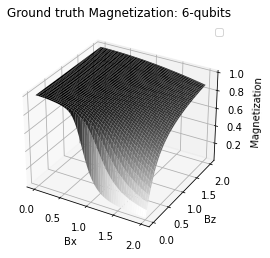

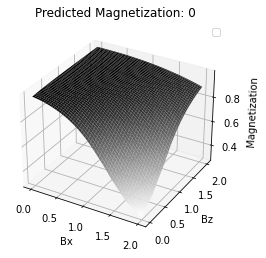

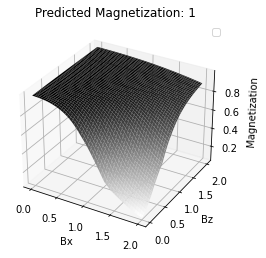

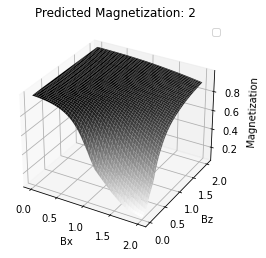

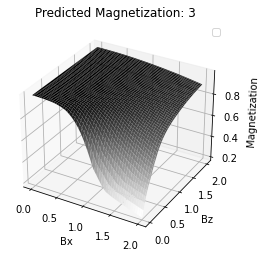

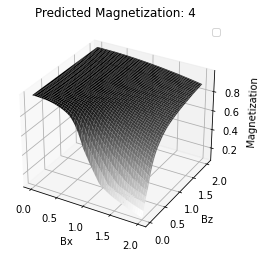

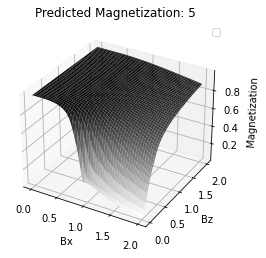

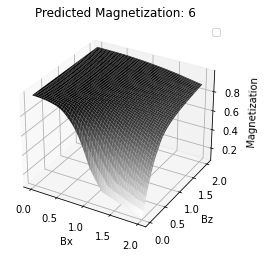

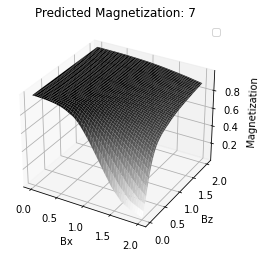

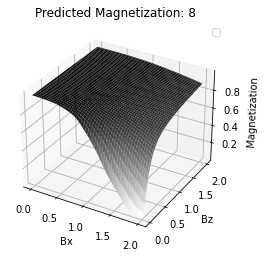

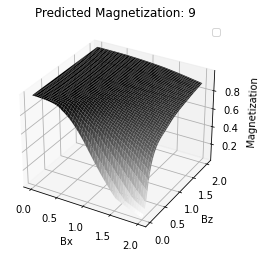

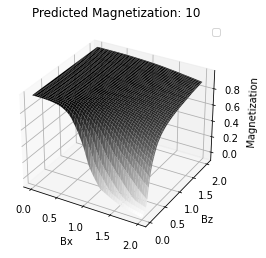

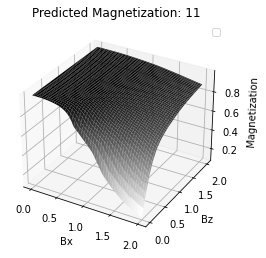

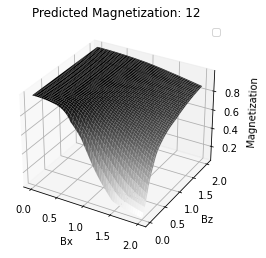

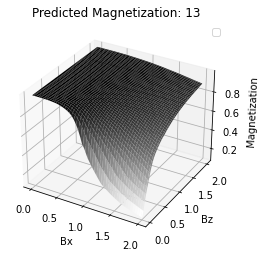

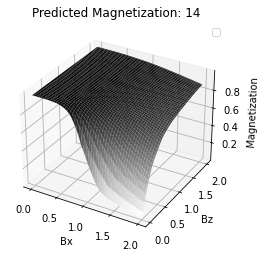

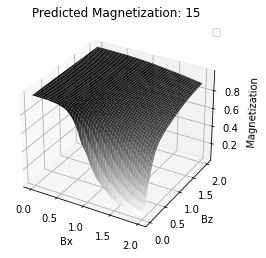

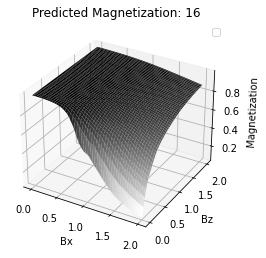

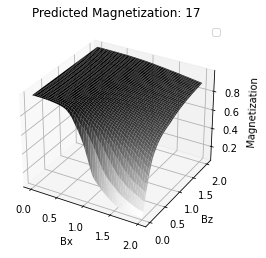

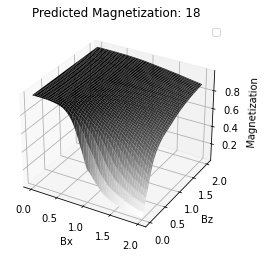

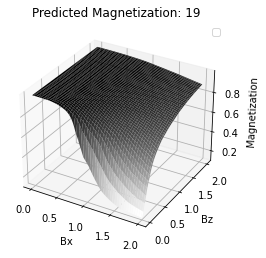

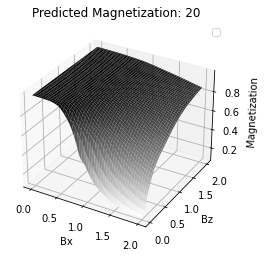

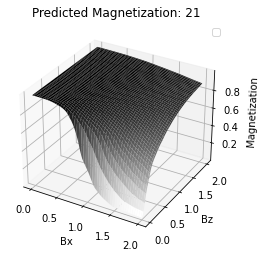

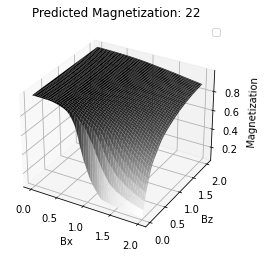

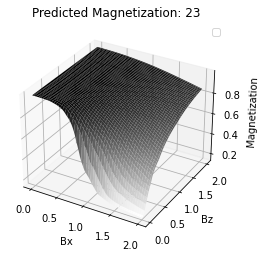

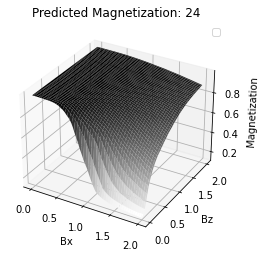

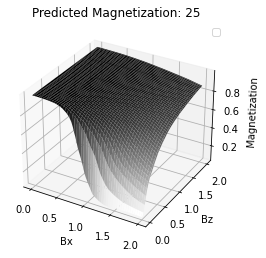

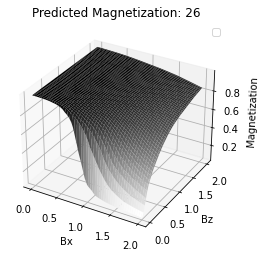

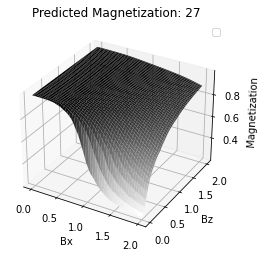

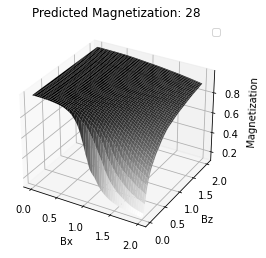

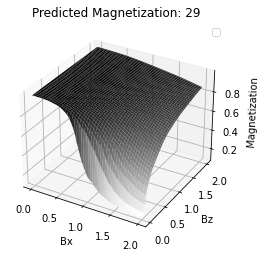

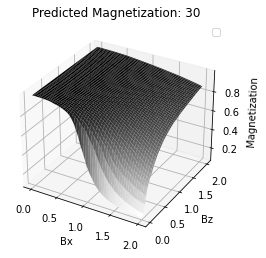

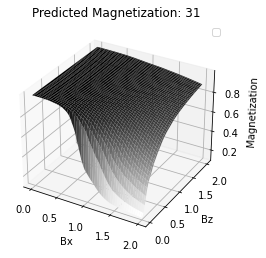

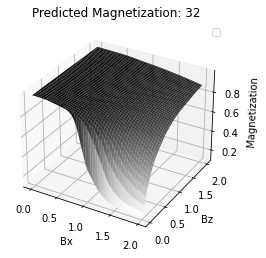

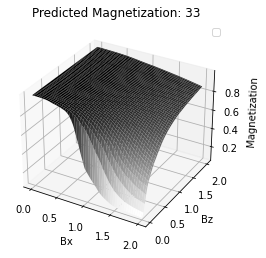

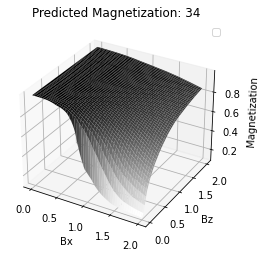

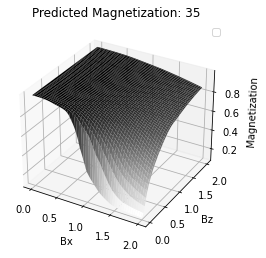

In [24]:
data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

x = np.reshape(Bx, (100, 100))
y = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 6-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bx")
    ax.set_ylabel("Bz")
    ax.set_zlabel("Magnetization")

    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-25-0b608726b715>:20: RuntimeWarning: More tha

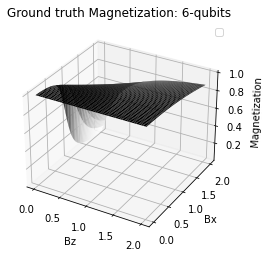

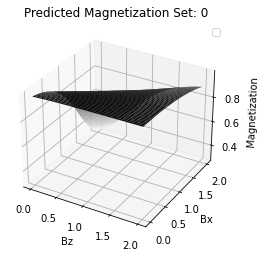

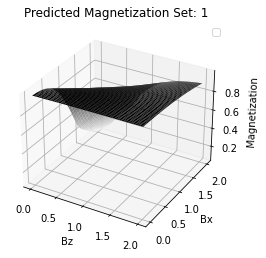

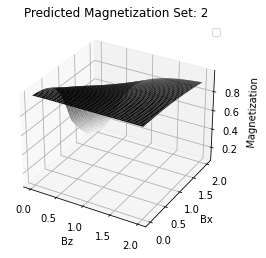

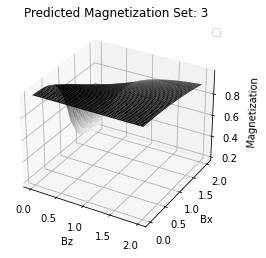

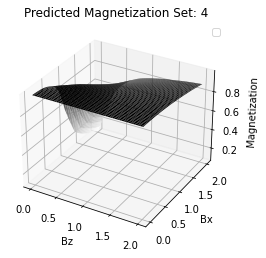

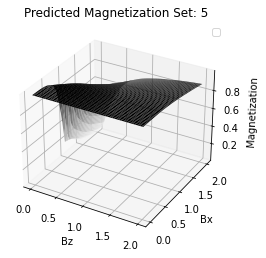

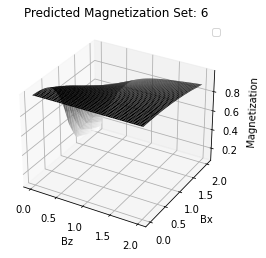

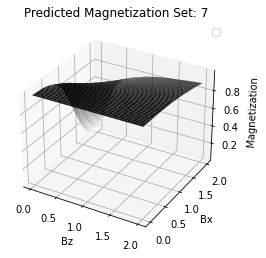

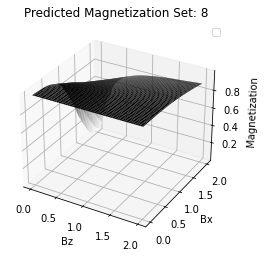

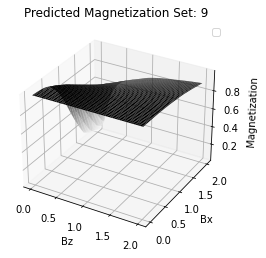

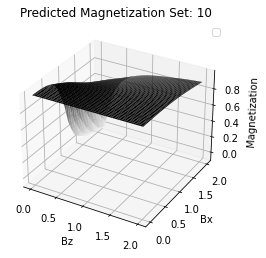

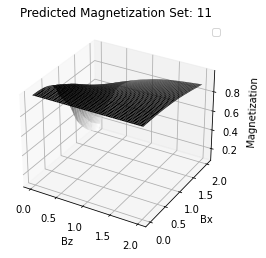

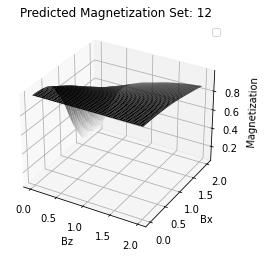

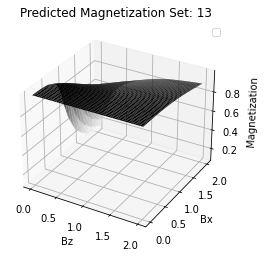

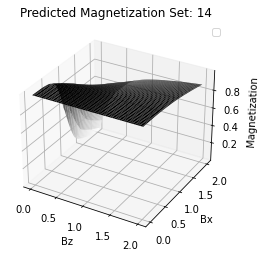

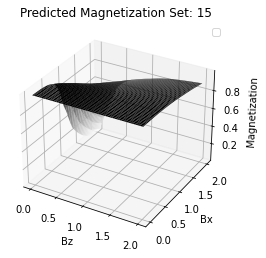

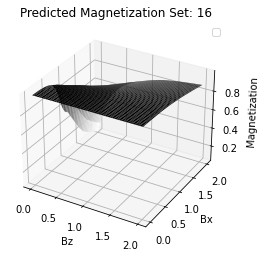

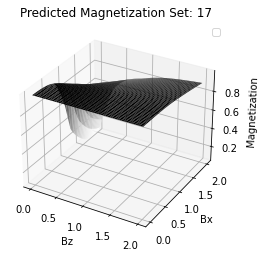

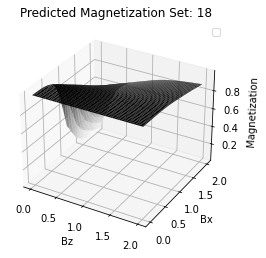

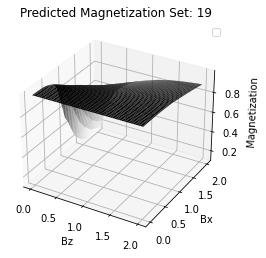

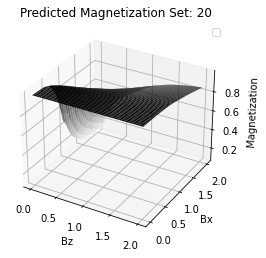

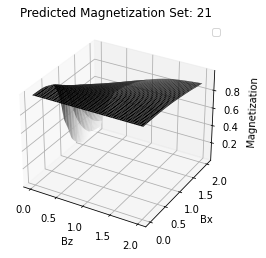

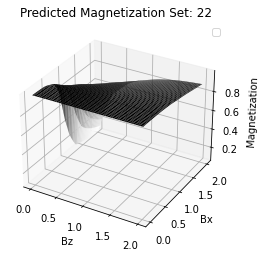

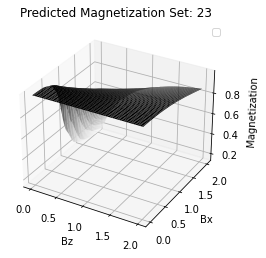

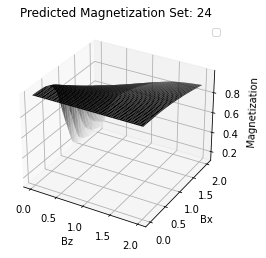

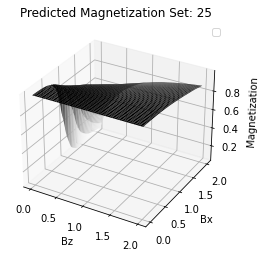

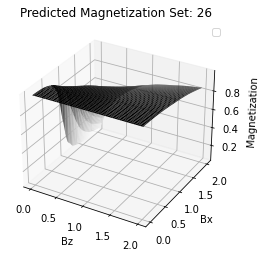

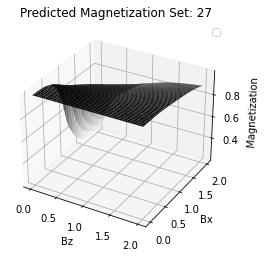

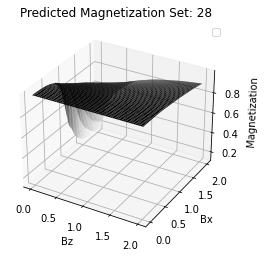

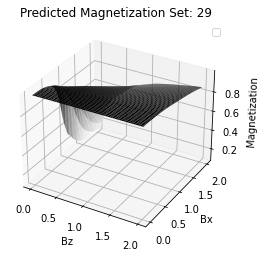

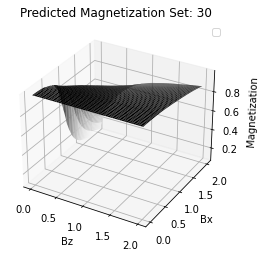

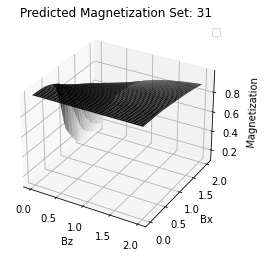

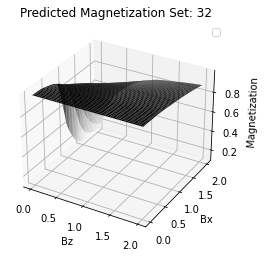

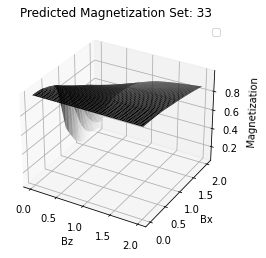

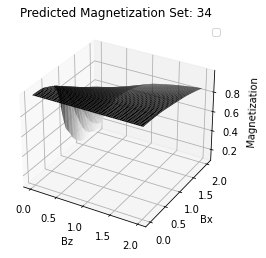

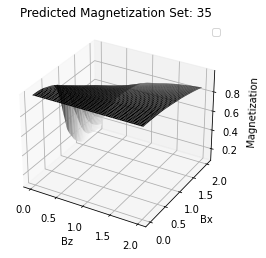

In [25]:
y = np.reshape(Bx, (100, 100))
x = np.reshape(Bz, (100, 100))
z = np.reshape(mag_6_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 6-qubits")
ax.set_xlabel("Bz")
ax.set_ylabel("Bx")
ax.set_zlabel("Magnetization")

for i in range (runs):
    z = np.reshape(magnetization_6[i], (100, 100))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, cmap="binary")

    ax.legend()
    name = "Predicted Magnetization Set: " + str(i)
    ax.set_title(name)
    ax.set_xlabel("Bz")
    ax.set_ylabel("Bx")
    ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

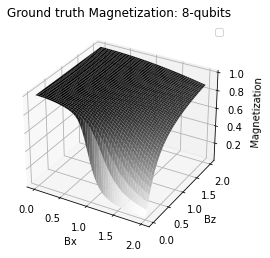

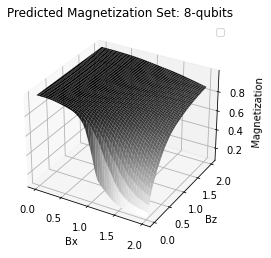

In [26]:
data_graph = np.load(data_8)
Bx = data_graph['fields'].T[8]
Bz = data_graph['fields'].T[16]

x = np.reshape(Bx, (50, 50))
y = np.reshape(Bz, (50, 50))
z = np.reshape(mag_8_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 8-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_8, (50, 50))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 8-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

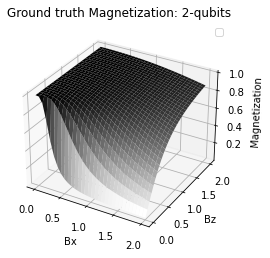

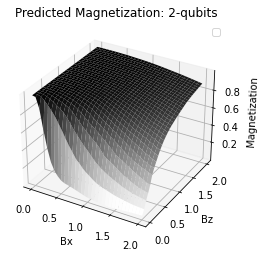

In [27]:
data_graph = np.load(v_data_2)
Bx = data_graph['fields'].T[2]
Bz = data_graph['fields'].T[4]

x = np.reshape(Bx, (33, 33))
y = np.reshape(Bz, (33, 33))
z = np.reshape(mag_2_t, (33, 33))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 2-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_2, (33, 33))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 2-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

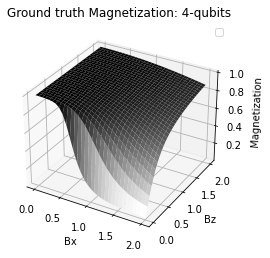

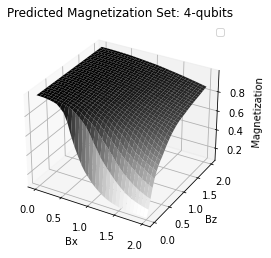

In [28]:
data_graph = np.load(v_data_4)
Bx = data_graph['fields'].T[4]
Bz = data_graph['fields'].T[8]

x = np.reshape(Bx, (33, 33))
y = np.reshape(Bz, (33, 33))
z = np.reshape(mag_4_t, (33, 33))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 4-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_4, (33, 33))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 4-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

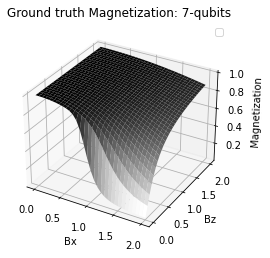

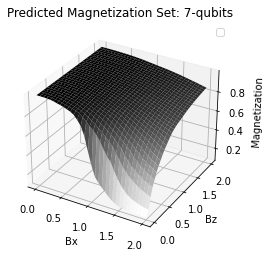

In [29]:
data_graph = np.load(v_data_7)
Bx = data_graph['fields'].T[7]
Bz = data_graph['fields'].T[14]

x = np.reshape(Bx, (33, 33))
y = np.reshape(Bz, (33, 33))
z = np.reshape(mag_7_t, (33, 33))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 7-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_7, (33, 33))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization Set: 7-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

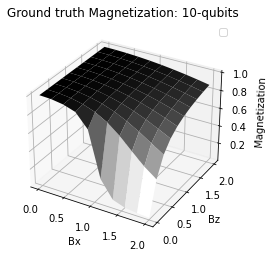

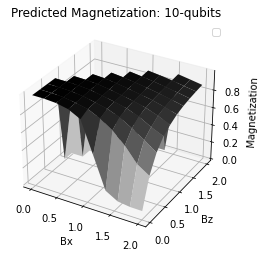

In [30]:
data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

x = np.reshape(Bx, (10, 10))
y = np.reshape(Bz, (10, 10))
z = np.reshape(mag_10_t, (10, 10))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 10-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_10, (10, 10))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 10-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

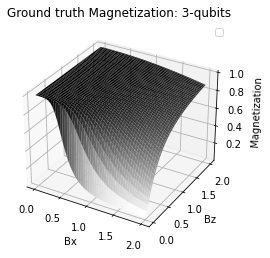

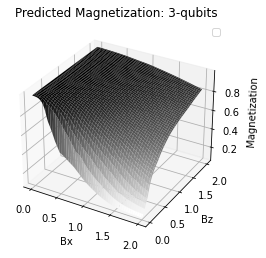

In [31]:
data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

x = np.reshape(Bx, (100, 100))
y = np.reshape(Bz, (100, 100))
z = np.reshape(mag_3_t, (100, 100))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 3-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_3, (100, 100))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 3-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Magnetization')

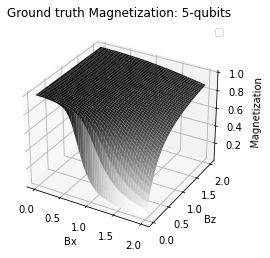

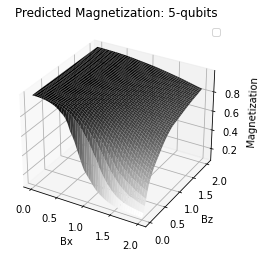

In [32]:
data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

x = np.reshape(Bx, (50, 50))
y = np.reshape(Bz, (50, 50))
z = np.reshape(mag_5_t, (50, 50))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
ax.set_title("Ground truth Magnetization: 5-qubits")
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")


z = np.reshape(mag_5, (50, 50))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap="binary")

ax.legend()
name = "Predicted Magnetization: 5-qubits"
ax.set_title(name)
ax.set_xlabel("Bx")
ax.set_ylabel("Bz")
ax.set_zlabel("Magnetization")

Set  0 :


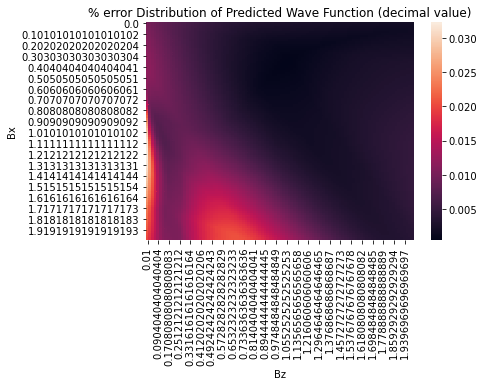

Set  1 :


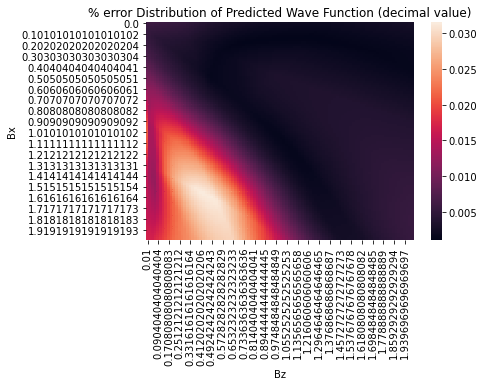

Set  2 :


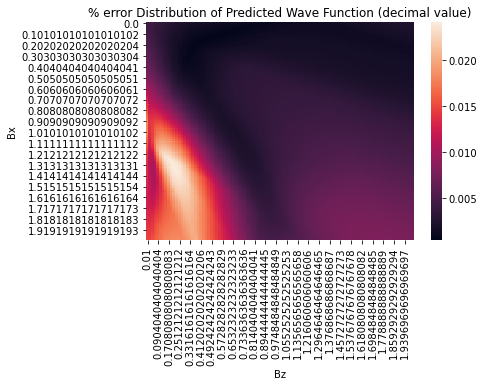

Set  3 :


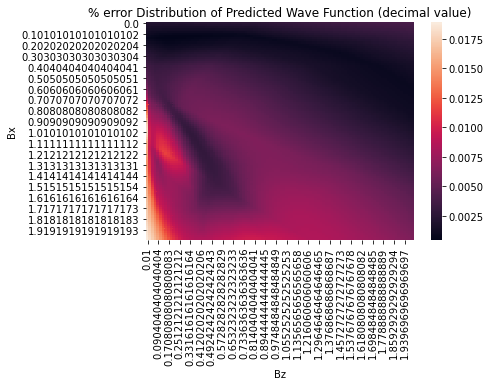

Set  4 :


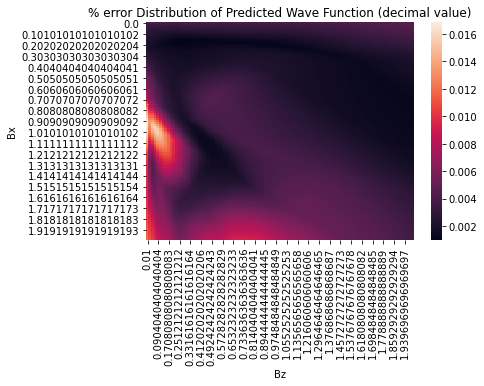

Set  5 :


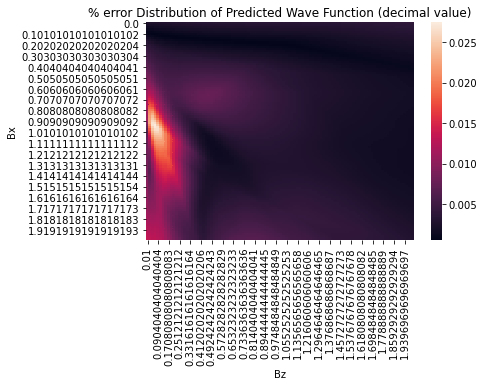

Set  6 :


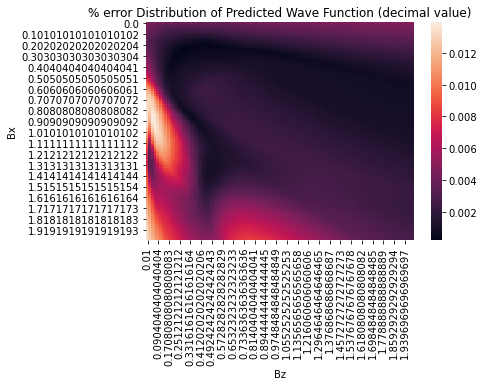

Set  7 :


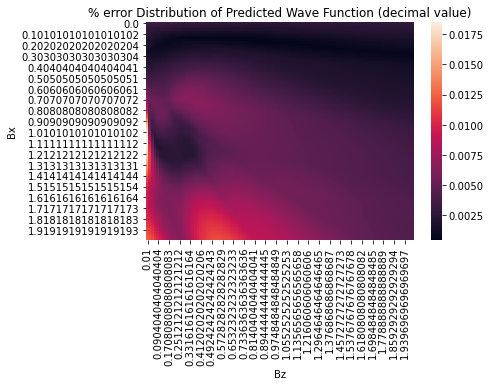

Set  8 :


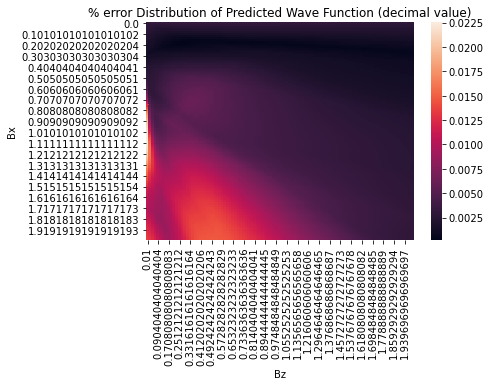

Set  9 :


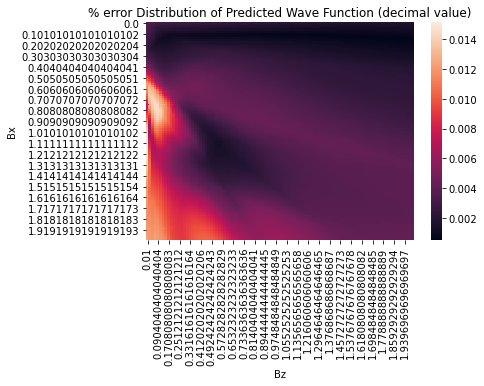

Set  10 :


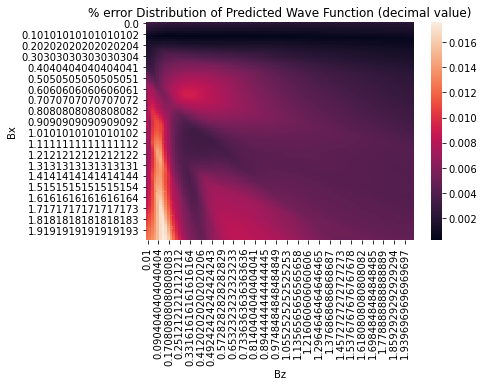

Set  11 :


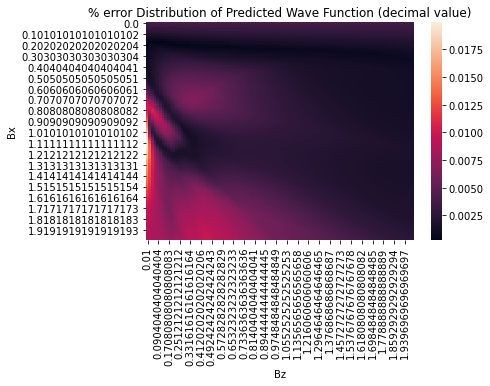

Set  12 :


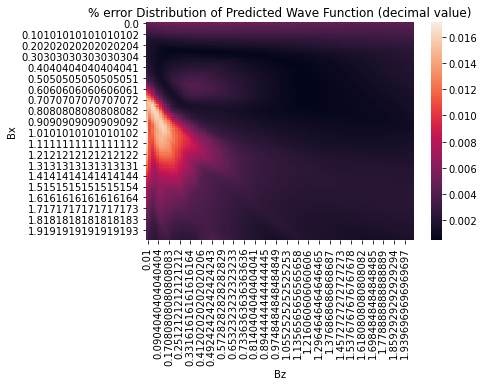

Set  13 :


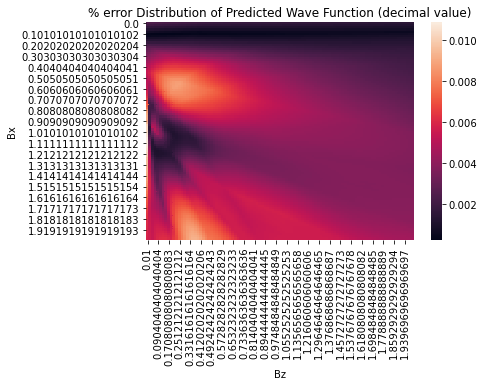

Set  14 :


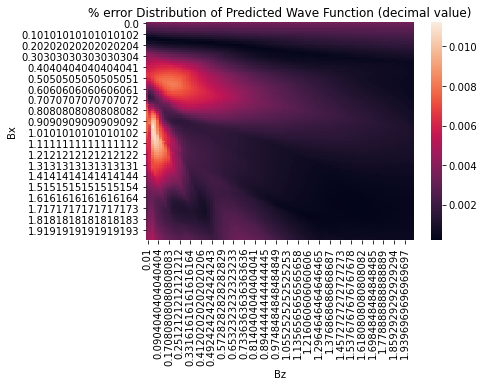

Set  15 :


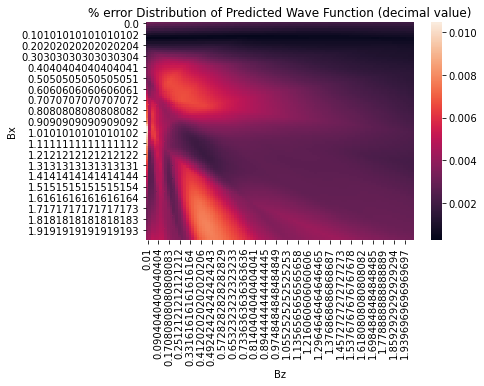

Set  16 :


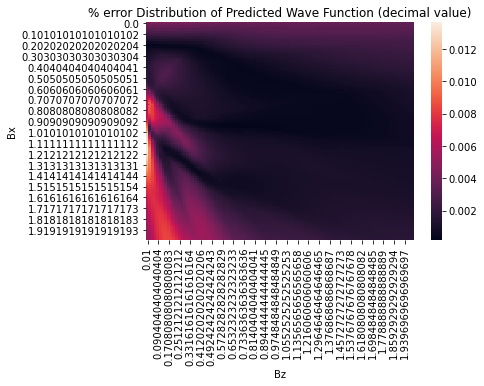

Set  17 :


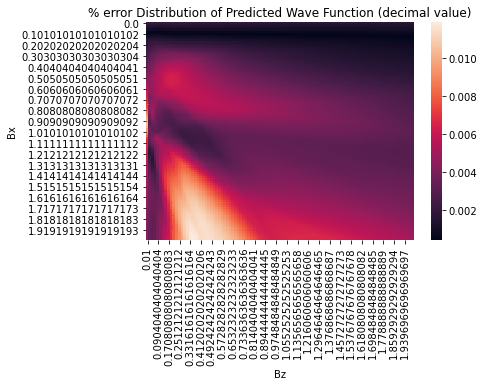

Set  18 :


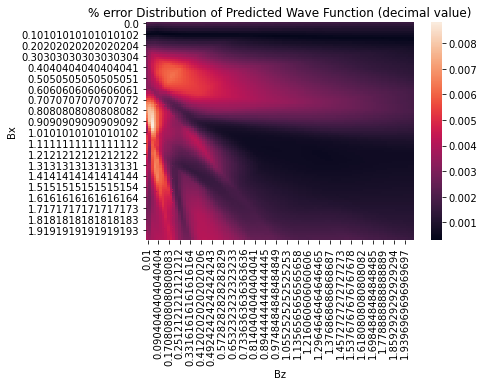

Set  19 :


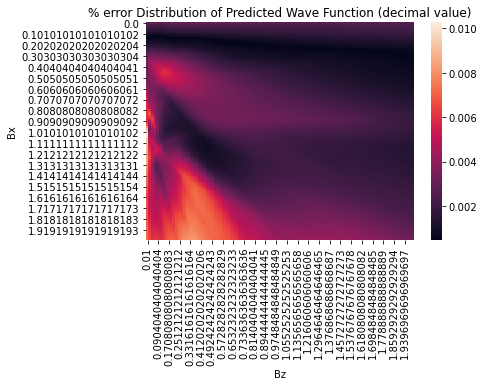

Set  20 :


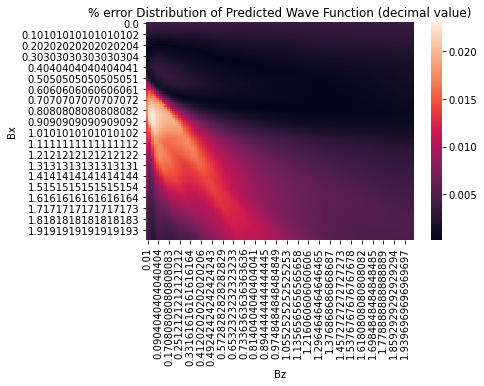

Set  21 :


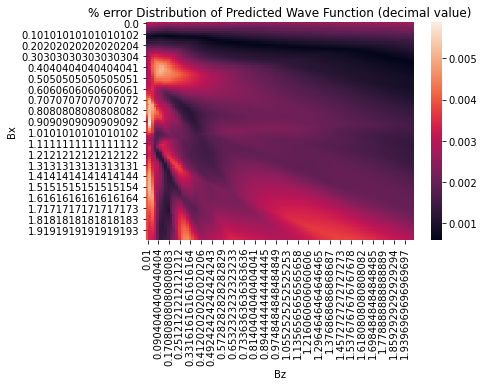

Set  22 :


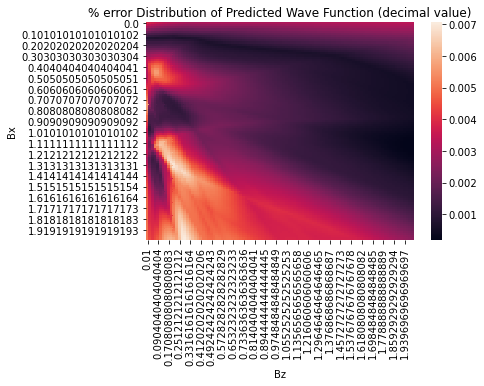

Set  23 :


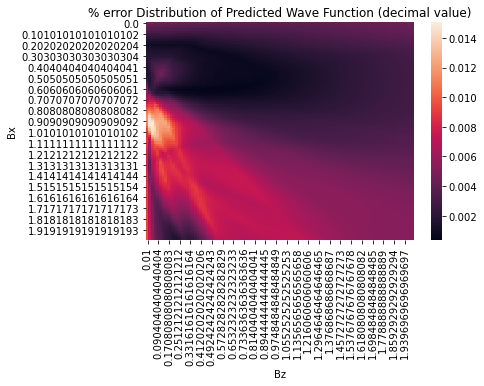

Set  24 :


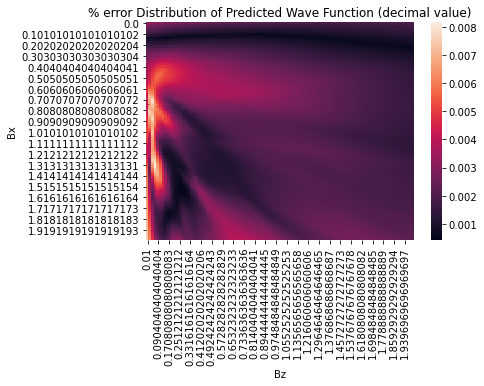

Set  25 :


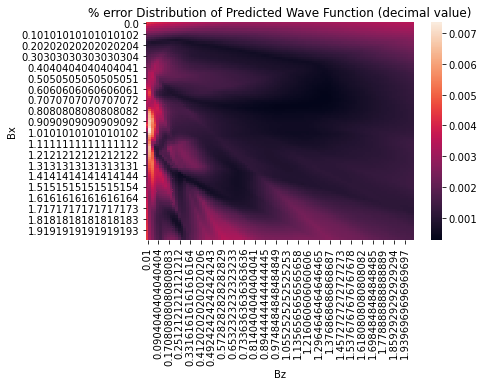

Set  26 :


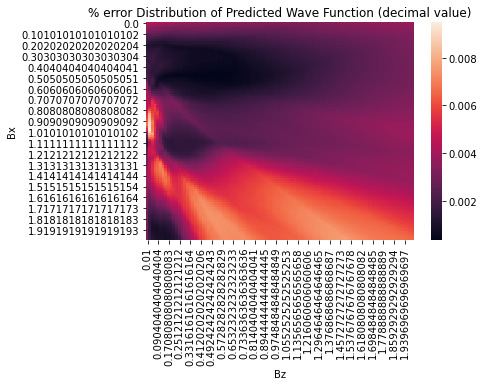

Set  27 :


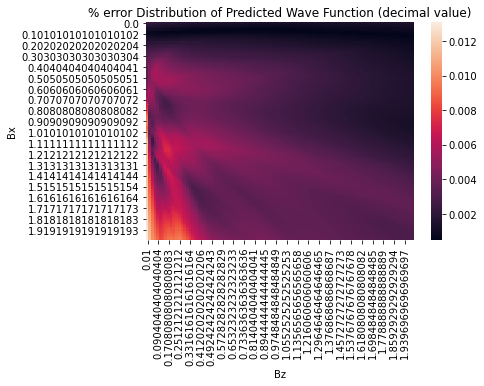

Set  28 :


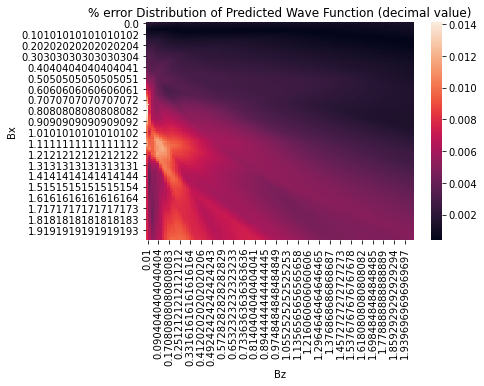

Set  29 :


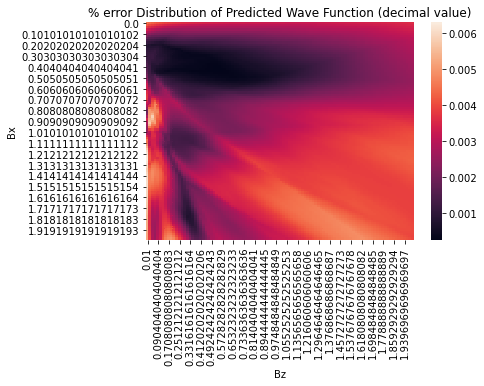

Set  30 :


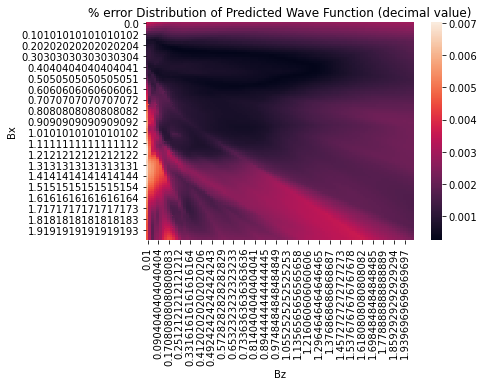

Set  31 :


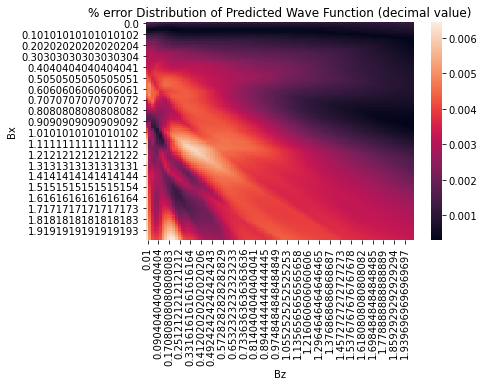

Set  32 :


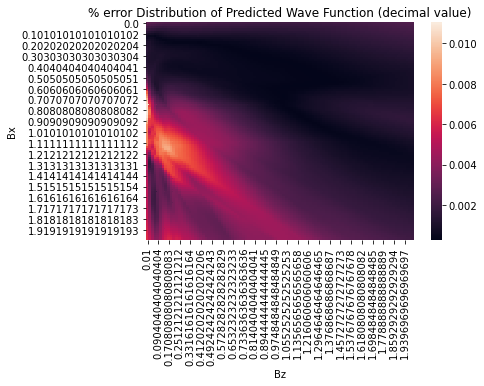

Set  33 :


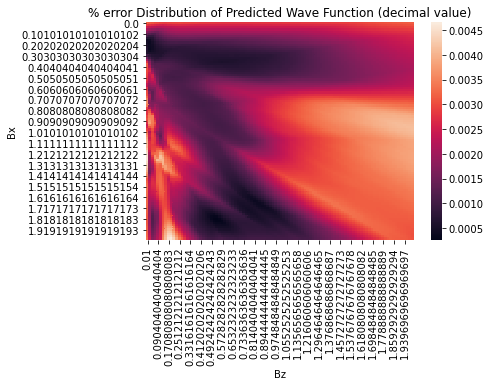

Set  34 :


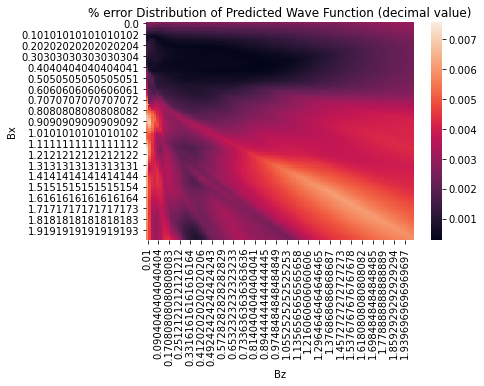

Set  35 :


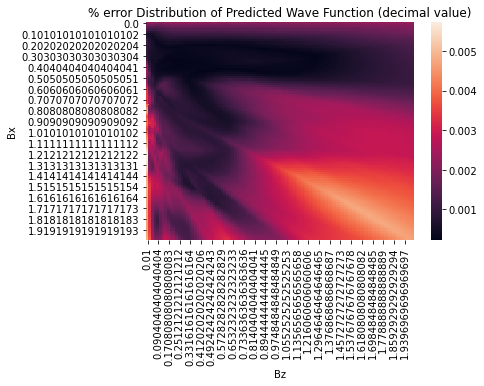

In [33]:
import pandas as pd
import seaborn as sns

data_graph = np.load(data_6)
Bx = data_graph['fields'].T[6]
Bz = data_graph['fields'].T[12]

count = 0
for i in error_p:
    print("Set ", count,":")
    data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': i})
    data = data.pivot(index='Bx', columns='Bz', values='% error')
#    plt.hist2d(Bx, By, bins=N_bins, cmap='plasma')
    sns.heatmap(data)

    # Plot a colorbar with label.
#    cb = plt.colorbar()

    # Add title and labels to plot.
    plt.title('% error Distribution of Predicted Wave Function (decimal value)')
#     plt.xlabel('Bx')
#     plt.ylabel('Bz')

    # Show the plot.
    plt.show()
    count+=1

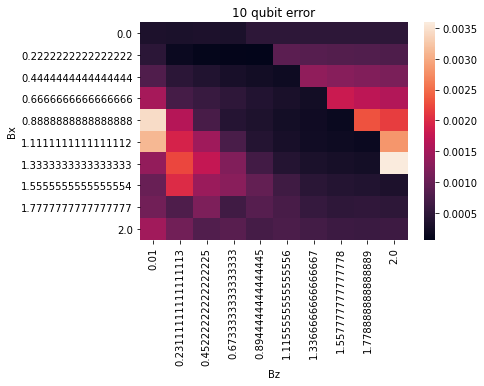

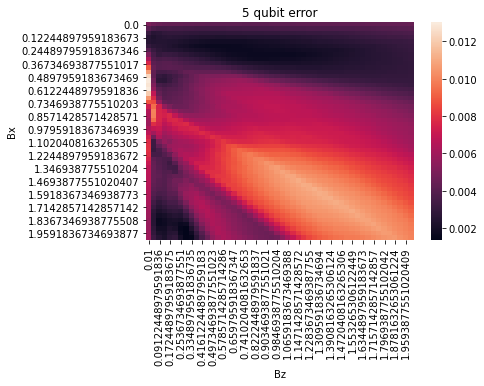

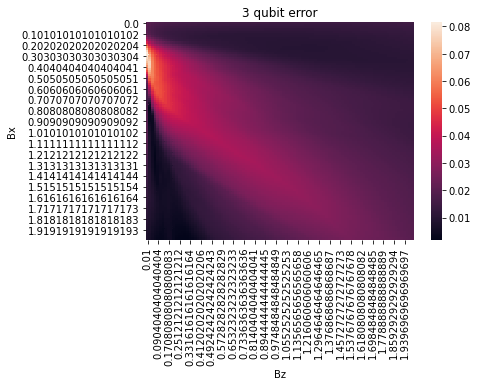

In [34]:
data_graph = np.load(data_10)
Bx = data_graph['fields'].T[10]
Bz = data_graph['fields'].T[20]

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_data(data_y_10,data_y_10_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
sns.heatmap(data)
plt.title('10 qubit error')
plt.show()

data_graph = np.load(data_5)
Bx = data_graph['fields'].T[5]
Bz = data_graph['fields'].T[10]

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_data(data_y_5,data_y_5_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
sns.heatmap(data)
plt.title('5 qubit error')
plt.show()

data_graph = np.load(data_3)
Bx = data_graph['fields'].T[3]
Bz = data_graph['fields'].T[6]

data = pd.DataFrame(data={'Bx':Bx, 'Bz':Bz, '% error': error_data(data_y_3,data_y_3_t)})
data = data.pivot(index='Bx', columns='Bz', values='% error')
sns.heatmap(data)
plt.title('3 qubit error')
plt.show()

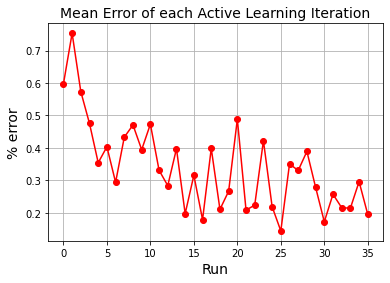

In [35]:
mean_dat = np.mean(error_p,axis = 1)*100

x_ax = np.arange(len(mean_dat))

plt.plot(x_ax, mean_dat, color='red', marker='o')
plt.title('Mean Error of each Active Learning Iteration', fontsize=14)
plt.xlabel('Run', fontsize=14)
plt.ylabel('% error', fontsize=14)
plt.grid(True)
plt.show()

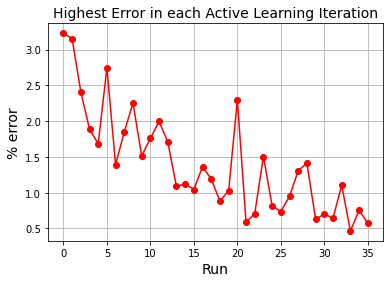

In [36]:
sorted_data = np.sort(error_p, axis = 1)
max_dat = []
for i in sorted_data:
    max_dat.append(i[len(i)-1]*100)

plt.plot(x_ax, max_dat, color='red', marker='o')
plt.title('Highest Error in each Active Learning Iteration', fontsize=14)
plt.xlabel('Run', fontsize=14)
plt.ylabel('% error', fontsize=14)
plt.grid(True)
plt.show()